
# Indo Ecotourism — Neural Recommender (TensorFlow Recommenders)

Notebook ini membangun **Neural Content-Based Retrieval** berbasis **Two‑Tower (user/query tower & item tower)** menggunakan **TensorFlow Recommenders (TFRS)**.  
Setiap cell diberi heading + paragraf ringkas. Di akhir, kita tampilkan metrik: **P@1, Recall@K, MRR, nDCG@10, Latency** dan justifikasinya.



## [1] Setup & Install

Instal TensorFlow Recommenders bila belum tersedia. Anda bisa melewati baris pip jika environment sudah siap.


In [4]:
!pip -q install -U tensorflow tensorflow-recommenders

import os, re, random, math, time, json, numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf, tensorflow_recommenders as tfrs

print("TF:", tf.__version__, "| TFRS:", tfrs.__version__)
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

BASE_DIR = Path.cwd()
ART_DIR  = BASE_DIR / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)


TF: 2.20.0 | TFRS: v0.7.3



## [2] Load Data + EDA Ringkas

Memuat `artifacts/items.csv` dari notebook CBF. Kita pastikan kolom penting untuk UI & training tersedia.  
Kalau `gabungan` belum ada, kita bentuk dari `place_description + category + city + place_name`.


=== ITEMS ===
items shape: (182, 10)
unique item_id: 182 | duplicates item_id: 0
empty 'gabungan': 0
avg desc length (chars): 418.45604395604397


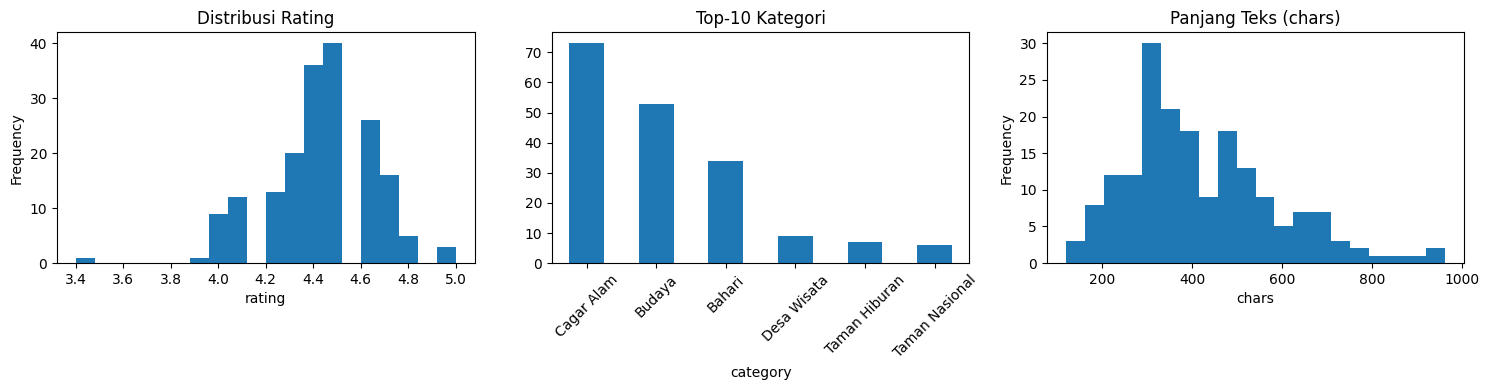

In [5]:
items_path = ART_DIR / "items.csv"
if not items_path.exists():
    raise FileNotFoundError("artifacts/items.csv tidak ditemukan. Siapkan dari notebook CBF.")

items = pd.read_csv(items_path)

# Lengkapi kolom penting
for col in ["place_name","category","city","rating","price","place_img","place_map","place_description"]:
    if col not in items.columns: items[col] = np.nan

# gabungan teks (fallback)
if "gabungan" not in items.columns:
    def _mk_text(r):
        parts = [str(r.get("place_description","")),
                 str(r.get("category","")),
                 str(r.get("city","")),
                 str(r.get("place_name",""))]
        return " ".join([p for p in parts if isinstance(p,str)]).strip()
    items["gabungan"] = items.apply(_mk_text, axis=1)

# item_id string (stabil untuk ekspor)
items["item_id"] = items["item_id"].astype(str) if "item_id" in items.columns else items.index.astype(str)

# Bersihkan
items["gabungan"] = items["gabungan"].astype(str).str.strip()
items = items.dropna(subset=["gabungan"]).reset_index(drop=True)

print("=== ITEMS ===")
print("items shape:", items.shape)
print("unique item_id:", items["item_id"].nunique(), "| duplicates item_id:", len(items) - items["item_id"].nunique())
print("empty 'gabungan':", int((items["gabungan"].str.len()==0).sum()))
print("avg desc length (chars):", float(items["gabungan"].str.len().mean()))

# Visual ringkas
fig, ax = plt.subplots(1, 3, figsize=(15,4))
items["rating"].astype(float).plot(kind="hist", bins=20, ax=ax[0], title="Distribusi Rating"); ax[0].set_xlabel("rating")
items["category"].fillna("UNKNOWN").str.split(",").str[0].value_counts().head(10).plot(kind="bar", ax=ax[1], title="Top-10 Kategori"); ax[1].tick_params(axis='x', rotation=45)
items["gabungan"].str.len().plot(kind="hist", bins=20, ax=ax[2], title="Panjang Teks (chars)"); ax[2].set_xlabel("chars")
plt.tight_layout(); plt.show()



## [3] Pairs: beberapa query per item (structured + keywords)

Kita hasilkan beberapa **query sintetis** per item (struktur nama/kategori/kota + sampling keywords dari teks).  
Pairs ini dipakai untuk **retrieval training** (in‑batch negatives). Split dilakukan row‑wise (90/10).


In [6]:

def q_struct_v1(row):
    cat = str(row.get("category","")).split(",")[0].strip()
    city= str(row.get("city","")).strip()
    name= str(row.get("place_name","")).strip()
    toks = [w for w in [cat, city, name] if w]
    return " ".join(toks).strip()

def q_struct_v2(row):
    cat = str(row.get("category","")).split(",")[0].strip().lower()
    city= str(row.get("city","")).strip().lower()
    q = "wisata"
    if cat:  q += f" {cat}"
    if city: q += f" di {city}"
    return q.strip()

def take_keywords(s, k):
    toks = re.findall(r"\w+", str(s).lower())
    toks = [t for t in toks if len(t) > 2]
    random.shuffle(toks)
    return " ".join(toks[:k]) if toks else ""

rows = []
for _, r in items.iterrows():
    iid = r["item_id"]; g = r["gabungan"]
    rows += [
        {"query_text": q_struct_v1(r), "item_id": iid},
        {"query_text": q_struct_v2(r), "item_id": iid},
    ]
    for k in (6, 8, 10):
        rows.append({"query_text": take_keywords(g, k=k), "item_id": iid})

pairs = pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)
pairs = pairs[pairs["query_text"].astype(str).str.len() > 0].reset_index(drop=True)

# Split 90/10 row-wise (sederhana & cukup untuk offline eval)
msk      = np.random.RandomState(SEED).rand(len(pairs)) < 0.90
train_df = pairs[msk].reset_index(drop=True)
val_df   = pairs[~msk].reset_index(drop=True)

print("=== PAIRS ===")
print("pairs shape:", pairs.shape, "| unique item_id in pairs:", pairs["item_id"].nunique())
print("train/val:", train_df.shape, val_df.shape)
print(pairs.head(5))


=== PAIRS ===
pairs shape: (910, 2) | unique item_id in pairs: 182
train/val: (818, 2) (92, 2)
                                          query_text item_id
0           Budaya Aceh Taman Nasional Gunung Leuser       0
1                              wisata budaya di aceh       0
2          nasional leuser yang fauna sumatera salah       0
3  sumatera indonesia sumatera lindung taman tama...       0
4  lindung termasuk taman harimau satu flora nasi...       0



## [4] Vectorizer bersama + Two‑Tower

Menggunakan TextVectorization yang sama untuk user & item sehingga ruang token konsisten.  
Tower memakai Embedding bersama, GlobalAveragePooling, Dense + LayerNorm, dan UnitNormalization agar skor dot‑product mendekati cosine.


In [7]:

from tensorflow.keras import layers, models

EMB_DIM    = 128
MAX_TOKENS = 40_000
SEQ_LEN    = 64   # samakan untuk user & item agar tak perlu slicing

vec = layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQ_LEN,
    name="unified_vec",
)

adapt_corpus = pd.concat(
    [train_df["query_text"].astype(str), items["gabungan"].astype(str)],
    axis=0, ignore_index=True
).values
vec.adapt(tf.data.Dataset.from_tensor_slices(adapt_corpus).batch(1024))
vocab_size = vec.vocabulary_size()
print("vocab_size:", vocab_size)

shared_emb = layers.Embedding(
    input_dim=vocab_size, output_dim=EMB_DIM, mask_zero=True, name="shared_emb"
)

def make_tower(name: str):
    inp = layers.Input(shape=(), dtype=tf.string, name=f"{name}_text")
    tok = vec(inp)
    emb = shared_emb(tok)
    x   = layers.GlobalAveragePooling1D(name=f"{name}_avg")(emb)
    x   = layers.Dense(EMB_DIM, activation="relu", name=f"{name}_dense1")(x)
    x   = layers.Dropout(0.15, name=f"{name}_drop")(x)
    x   = layers.Dense(EMB_DIM, activation=None, name=f"{name}_dense2")(x)
    x   = layers.LayerNormalization(name=f"{name}_ln")(x)
    x   = layers.Activation("relu")(x)
    x   = layers.UnitNormalization(axis=-1, name=f"{name}_unitnorm")(x)  # L2 normalize
    return models.Model(inp, x, name=f"{name}_tower")

user_model = make_tower("user")
item_model = make_tower("item")


vocab_size: 2129



## [5] Dataset TF + Training (TFRS Retrieval)

Menyusun tf.data dari pasangan (query_text, item_text) dan melatih model TFRS Retrieval dengan in‑batch negatives.  
Kita gunakan callback untuk early stopping & reduce LR, dan logger sederhana agar output bersih.


In [8]:

# 1) Siapkan pasangan train/val
pair_train = train_df.merge(
    items[["item_id", "gabungan"]], on="item_id", how="left"
).rename(columns={"gabungan": "item_text"})
pair_val = val_df.merge(
    items[["item_id", "gabungan"]], on="item_id", how="left"
).rename(columns={"gabungan": "item_text"})

pair_train = pair_train.dropna(subset=["query_text", "item_text"]).reset_index(drop=True)
pair_val   = pair_val.dropna(subset=["query_text", "item_text"]).reset_index(drop=True)

# 2) Dataset tf.data
BATCH_SIZE = 256

def to_ds(df, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices({
        "query_text": df["query_text"].astype(str).values,
        "item_text":  df["item_text"].astype(str).values,
    })
    if shuffle:
        ds = ds.shuffle(min(20000, len(df)), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = to_ds(pair_train, shuffle=True)
val_ds   = to_ds(pair_val,   shuffle=False)

# 3) Model TFRS Retrieval (in-batch negatives) + loss rata-rata
mean_ce = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE
)

class RetrievalModel(tfrs.models.Model):
    def __init__(self, user_model, item_model):
        super().__init__()
        self.user_model = user_model
        self.item_model = item_model
        self.task = tfrs.tasks.Retrieval(loss=mean_ce, metrics=None)

    def compute_loss(self, features, training=False):
        u = self.user_model(features["query_text"])
        v = self.item_model(features["item_text"])
        return self.task(u, v)

model = RetrievalModel(user_model, item_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4))

# 4) Logger agar output rapi
class CleanLogger(tf.keras.callbacks.Callback):
    def __init__(self, show_lr=True, every=1, fmt="{:.4f}", fmt_lr="{:.6f}"):
        super().__init__()
        self.show_lr = show_lr; self.every = every
        self.fmt = fmt; self.fmt_lr = fmt_lr
    def _get_lr(self):
        try:
            lr = self.model.optimizer.learning_rate
            return float(lr.numpy()) if hasattr(lr, "numpy") else float(tf.keras.backend.get_value(lr))
        except Exception:
            return None
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.every != 0: return
        logs = logs or {}
        msg = f"Epoch {epoch+1}/{self.params.get('epochs','?')}"
        if "loss" in logs:     msg += f" | loss: {self.fmt.format(logs['loss'])}"
        if "val_loss" in logs: msg += f" | val_loss: {self.fmt.format(logs['val_loss'])}"
        if self.show_lr:
            lr = self._get_lr()
            if lr is not None: msg += f" | lr: {self.fmt_lr.format(lr)}"
        print(msg)

# 5) Callbacks & fit
cbs = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, min_delta=1e-3),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=0),
    CleanLogger(show_lr=True, every=1, fmt="{:.4f}", fmt_lr="{:.6f}"),
]

history = model.fit(train_ds, validation_data=val_ds, epochs=40, callbacks=cbs, verbose=0)


Epoch 1/40 | loss: 3.8736 | val_loss: 4.4796 | lr: 0.000500
Epoch 2/40 | loss: 3.7993 | val_loss: 4.4299 | lr: 0.000500
Epoch 3/40 | loss: 3.7190 | val_loss: 4.3847 | lr: 0.000500
Epoch 4/40 | loss: 3.6708 | val_loss: 4.3462 | lr: 0.000500
Epoch 5/40 | loss: 3.6144 | val_loss: 4.3113 | lr: 0.000500
Epoch 6/40 | loss: 3.5774 | val_loss: 4.2803 | lr: 0.000500
Epoch 7/40 | loss: 3.5177 | val_loss: 4.2509 | lr: 0.000500
Epoch 8/40 | loss: 3.4999 | val_loss: 4.2265 | lr: 0.000500
Epoch 9/40 | loss: 3.4952 | val_loss: 4.2078 | lr: 0.000500
Epoch 10/40 | loss: 3.4268 | val_loss: 4.1903 | lr: 0.000500
Epoch 11/40 | loss: 3.4153 | val_loss: 4.1750 | lr: 0.000500
Epoch 12/40 | loss: 3.3853 | val_loss: 4.1582 | lr: 0.000500
Epoch 13/40 | loss: 3.3860 | val_loss: 4.1447 | lr: 0.000500
Epoch 14/40 | loss: 3.3595 | val_loss: 4.1311 | lr: 0.000500
Epoch 15/40 | loss: 3.3509 | val_loss: 4.1195 | lr: 0.000500
Epoch 16/40 | loss: 3.3406 | val_loss: 4.1099 | lr: 0.000500
Epoch 17/40 | loss: 3.3099 | val_


## [6] Visualisasi kurva training

Kurva loss train vs val membantu memastikan tidak terjadi overfitting signifikan.


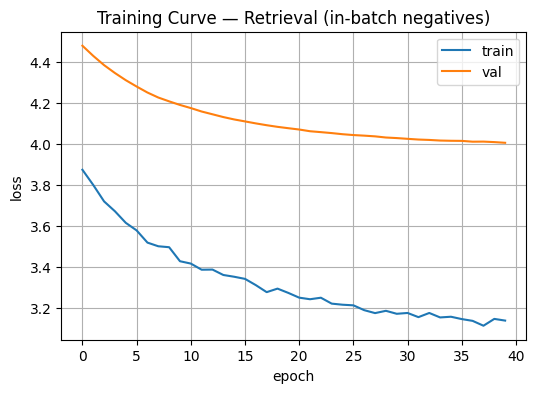

In [9]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Training Curve — Retrieval (in-batch negatives)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.grid(True); plt.legend(); plt.show()



## [7] Evaluasi Offline — P@1, Recall@K, MRR, nDCG@10, Latency

Kita embed seluruh item sekali, lalu untuk setiap query di val set hitung skor dot‑product dan ambil ranking.


In [10]:
K_EVAL = 10

def _embed_items(model, texts, batch=512):
    V = []
    for i in range(0, len(texts), batch):
        V.append(model(tf.constant(texts[i:i+batch])).numpy())
    return np.vstack(V).astype("float32")

def evaluate_pr_re_latency(user_model, item_model, val_df_join, items_text, k=10, batch=256):
    V = _embed_items(item_model, items_text)
    text2idx = {t: i for i, t in enumerate(items_text)}

    sum_prec = 0.0
    sum_rec  = 0.0
    sum_ms   = 0.0
    n        = 0

    for i in range(0, len(val_df_join), batch):
        q  = val_df_join["query_text"].astype(str).values[i:i+batch]
        gt = val_df_join["item_text"].astype(str).values[i:i+batch]

        t0 = time.perf_counter()
        U  = user_model(tf.constant(q)).numpy()
        sims = U @ V.T
        ms_per = ((time.perf_counter() - t0) * 1000.0) / max(1, len(q))

        topk_idx = np.argsort(-sims, axis=1)[:, :k]

        for r, t in enumerate(gt):
            gi = text2idx.get(t, -1)
            if gi < 0:
                continue
            hit = 1.0 if gi in topk_idx[r] else 0.0
            sum_prec += hit / k
            sum_rec  += hit
            sum_ms   += ms_per
            n        += 1

    return {
        f"precision@{k}": sum_prec / max(1, n),
        f"recall@{k}":    sum_rec  / max(1, n),
        "Latency(ms/q)":  sum_ms   / max(1, n),
    }

items_text = items["gabungan"].astype(str).tolist()
val_join   = val_df.merge(
    items[["item_id", "gabungan"]],
    on="item_id", how="left"
).rename(columns={"gabungan": "item_text"}).dropna(subset=["item_text"]).reset_index(drop=True)

metrics = evaluate_pr_re_latency(user_model, item_model, val_join, items_text, k=K_EVAL)

tbl = pd.DataFrame([metrics])
order_cols = [f"precision@{K_EVAL}", f"recall@{K_EVAL}", "Latency(ms/q)"]
tbl = tbl.reindex(columns=order_cols)

try:
    display(
        tbl.style.format({f"precision@{K_EVAL}":"{:.3f}", f"recall@{K_EVAL}":"{:.3f}", "Latency(ms/q)":"{:.2f}"})
           .background_gradient(cmap="Blues")
    )
except Exception:
    display(tbl)

print("Raw metrics:", metrics)

,precision@10,recall@10,Latency(ms/q)
0,0.058,0.576,0.20


Raw metrics: {'precision@10': 0.05760869565217388, 'recall@10': 0.5760869565217391, 'Latency(ms/q)': 0.19543011956473122}



## [8] Export Artefak

Menyimpan encoder `.keras`, matriks embedding item `.npy`, pemetaan indeks, dan metadata sederhana.


In [11]:
# 8.1 mapping row_idx <-> item_id
item_id_map = items[["item_id","place_name","category","city"]].copy()
item_id_map.insert(0, "row_idx", np.arange(len(items)))
item_id_map.to_csv(ART_DIR / "item_id_map.csv", index=False)
print("Saved:", (ART_DIR / "item_id_map.csv").as_posix())

# 8.2 simpan encoder
user_encoder_path = (ART_DIR / "user_encoder.keras").as_posix()
item_encoder_path = (ART_DIR / "item_encoder.keras").as_posix()
tf.keras.models.save_model(user_model, user_encoder_path, include_optimizer=False)
tf.keras.models.save_model(item_model, item_encoder_path, include_optimizer=False)
print("Saved:", user_encoder_path)
print("Saved:", item_encoder_path)

# 8.3 precompute item embeddings (N, D)
def compute_item_matrix(model, texts, batch=512):
    out = []
    for i in range(0, len(texts), batch):
        out.append(model(tf.constant(texts[i:i+batch])).numpy())
    return np.vstack(out).astype("float32")

ITEM_EMBS = compute_item_matrix(item_model, items_text, batch=512)
np.save(ART_DIR / "item_embeddings.npy", ITEM_EMBS)
print("Saved:", (ART_DIR / "item_embeddings.npy").as_posix(), "| shape:", ITEM_EMBS.shape)

# 8.4 metadata
meta = {
    "created_at": time.strftime("%Y-%m-%dT%H:%M:%SZ", time.gmtime()),
    "emb_dim": int(ITEM_EMBS.shape[1]),
    "max_tokens": int(vec.vocabulary_size()),
    "seq_len": 64,
    "train_pairs": int(len(train_df)),
    "val_pairs": int(len(val_df)),
}
with open(ART_DIR / "neural_metadata.json", "w") as f:
    json.dump(meta, f, indent=2)
print("Saved:", (ART_DIR / "neural_metadata.json").as_posix())

# 8.5 sanity check retrieval
def retrieve_local(query: str, k=10):
    u = tf.keras.models.load_model(user_encoder_path, compile=False)
    ue = u(tf.constant([query])).numpy().astype("float32")            # (1, D)
    scores = (ue @ ITEM_EMBS.T).ravel()                               # (N,)
    topk = np.argsort(-scores)[:k]
    return [(items.loc[i, "item_id"], float(scores[i])) for i in topk]

print("Sample:", retrieve_local("pantai aceh snorkeling", k=5))


Saved: /content/artifacts/item_id_map.csv
Saved: /content/artifacts/user_encoder.keras
Saved: /content/artifacts/item_encoder.keras
Saved: /content/artifacts/item_embeddings.npy | shape: (182, 128)
Saved: /content/artifacts/neural_metadata.json
Sample: [('164', 0.9007214307785034), ('151', 0.8852977752685547), ('154', 0.8848141431808472), ('169', 0.8842567205429077), ('165', 0.8830888867378235)]



## [9] Inference Sanity Check

Contoh fungsi inference mandiri yang memuat encoder, embedding item, dan mengembalikan Top‑K item beserta skornya.


In [12]:

# Paths
user_encoder_path = (ART_DIR / "user_encoder.keras")
item_encoder_path = (ART_DIR / "item_encoder.keras")
embs_path         = (ART_DIR / "item_embeddings.npy")
idmap_path        = (ART_DIR / "item_id_map.csv")
items_csv_path    = (ART_DIR / "items.csv")

# Load items & ensure item_id exists
items_inf = pd.read_csv(items_csv_path)
if "item_id" not in items_inf.columns:
    items_inf["item_id"] = items_inf.index.astype(str)
items_inf["item_id"] = items_inf["item_id"].astype(str)
items_text_inf = items_inf["gabungan"].astype(str).tolist()

# Load user encoder
user_encoder = tf.keras.models.load_model(user_encoder_path.as_posix(), compile=False)

# Load/precompute item embeddings
if embs_path.exists():
    ITEM_EMBS_INF = np.load(embs_path).astype("float32")
else:
    item_encoder = tf.keras.models.load_model(item_encoder_path.as_posix(), compile=False)
    chunks, vecs = 512, []
    for i in range(0, len(items_text_inf), chunks):
        vecs.append(item_encoder(tf.constant(items_text_inf[i:i+chunks])).numpy())
    ITEM_EMBS_INF = np.vstack(vecs).astype("float32")

assert ITEM_EMBS_INF.shape[0] == len(items_inf), "Mismatch N items vs embeddings"

# RowIdx <-> item_id map
if idmap_path.exists():
    idmap = pd.read_csv(idmap_path)
    row2id = dict(zip(idmap["row_idx"].astype(int), idmap["item_id"].astype(str)))
else:
    row2id = dict(zip(range(len(items_inf)), items_inf["item_id"].astype(str)))

def retrieve_local(query: str, k: int = 10):
    ue = user_encoder(tf.constant([query])).numpy().astype("float32")   # (1, D)
    scores = (ue @ ITEM_EMBS_INF.T).ravel()                              # (N,)
    top_idx = np.argsort(-scores)[:k]
    out = []
    for i in top_idx:
        iid  = row2id.get(int(i), items_inf.loc[i, "item_id"])
        name = items_inf.loc[i, "place_name"] if "place_name" in items_inf.columns else "-"
        out.append((iid, float(scores[i]), name))
    return out

# Demo
for q in ["pantai aceh snorkeling", "gunung camping bandung"]:
    print(f"\nQ: {q}")
    for iid, sc, name in retrieve_local(q, k=5):
        print(f"  {iid:>4} | {sc:.4f} | {name}")



Q: pantai aceh snorkeling
   164 | 0.9007 | Pantai Patihan
   151 | 0.8853 | Pantai Baron
   154 | 0.8848 | Pantai Greweng
   169 | 0.8843 | Pantai Timang
   165 | 0.8831 | Pantai Sadranan

Q: gunung camping bandung
    20 | 0.8080 | Kawah Putih
    38 | 0.7875 | Taman Wisata Alam Ranca Upas
     5 | 0.7778 | Bukit Moko
    16 | 0.7753 | Gunung Lalakon
    23 | 0.7746 | Kebun Tanaman Obat Sari Alam



## [10] Justifikasi & Penjelasan Metrik

Kenapa Neural Two‑Tower untuk CBF?  
1) Belajar representasi — kueri dan item relevan makin berdekatan meski kata kunci berbeda.  
2) Efisien di produksi — item embeddings bisa di‑precompute; inferensi cepat (dot‑product, bisa ANN/FAISS).  
3) Tidak butuh interaksi historis — tetap content‑based, cocok untuk cold‑start.  
4) Kualitas ranking — biasanya meningkatkan MRR dan nDCG@10 dibanding cosine statis.

Penjelasan metrik: P@1 (akurasi Top‑1), Recall@K (hit di Top‑K), MRR (rata‑rata 1/rank), nDCG@10 (kualitas urutan Top‑10 berbobot posisi), Latency (ms per query).
